In [1]:
import time
import psutil
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from RSA import generate_rsa_keys, rsa_decrypt, rsa_encrypt
from RSA_with_blinding import secure_decrypt
from Crypto.Util.number import bytes_to_long
from Crypto.Random import get_random_bytes




/home/kieron/.local/lib/python3.9/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


In [2]:
def monitor_cpu_times():
    # Get the CPU times of the current process
    cpu_times = psutil.Process().cpu_times()
    # Return user + system CPU times to capture the total CPU time consumed by the process
    return cpu_times.user + cpu_times.system


def monitor_performance(decrypt_function, args, num_iterations=500):
    cpu_time_usage = []
    decryption_times = []

    for _ in range(num_iterations):
        # Initiate CPU usage monitoring
        process = psutil.Process()
        process.cpu_percent(interval=None)  # Reset/initiate monitoring
        
        # Decryption and time measurement
        start_time = time.perf_counter()
        decrypt_function(*args)
        end_time = time.perf_counter()
        
        # Measure CPU utilization immediately after decryption
        cpu_usage = process.cpu_percent(interval=None)

        # Collect data
        decryption_times.append(end_time - start_time)
        cpu_time_usage.append(cpu_usage)

    return decryption_times, cpu_time_usage

In [3]:
# Assuming key_sizes is defined as before
key_sizes = [256, 512, 1024, 2048, 4096]

# Initialize empty lists for data collection
data = {
    'Key Size': [],
    'Decryption Time (s)': [],
    'CPU Usage (%)': [],
    'Method': []
}

# Loop through each key size and collect performance data
for size in key_sizes:
    print(f"Testing with key size: {size}")
    public_key, private_key = generate_rsa_keys(size)
    message_bytes = get_random_bytes(256)  # Generate message as bytes
    message_int = bytes_to_long(message_bytes)  # Convert message to integer
    ciphertext = rsa_encrypt(public_key, message_int)
    # Standard decryption performance monitoring
    dec_times_std, cpu_usages_std = monitor_performance(
        rsa_decrypt, [private_key, ciphertext], num_iterations=100)
    
    # Secure decryption with blinding performance monitoring
    dec_times_sec, cpu_usages_sec = monitor_performance(
        secure_decrypt, [ciphertext, private_key, public_key], num_iterations=100)
    
    # Append data for standard decryption
    for i in range(len(dec_times_std)):
        data['Key Size'].append(size)
        data['Decryption Time (s)'].append(dec_times_std[i])
        data['CPU Usage (%)'].append(cpu_usages_std[i])
        data['Method'].append('Standard')
        
    # Append data for secure decryption
    for i in range(len(dec_times_sec)):
        data['Key Size'].append(size)
        data['Decryption Time (s)'].append(dec_times_sec[i])
        data['CPU Usage (%)'].append(cpu_usages_sec[i])
        data['Method'].append('Secure')

# Create the DataFrame
df = pd.DataFrame(data)




Testing with key size: 256
Testing with key size: 512
Testing with key size: 1024
Testing with key size: 2048
Testing with key size: 4096


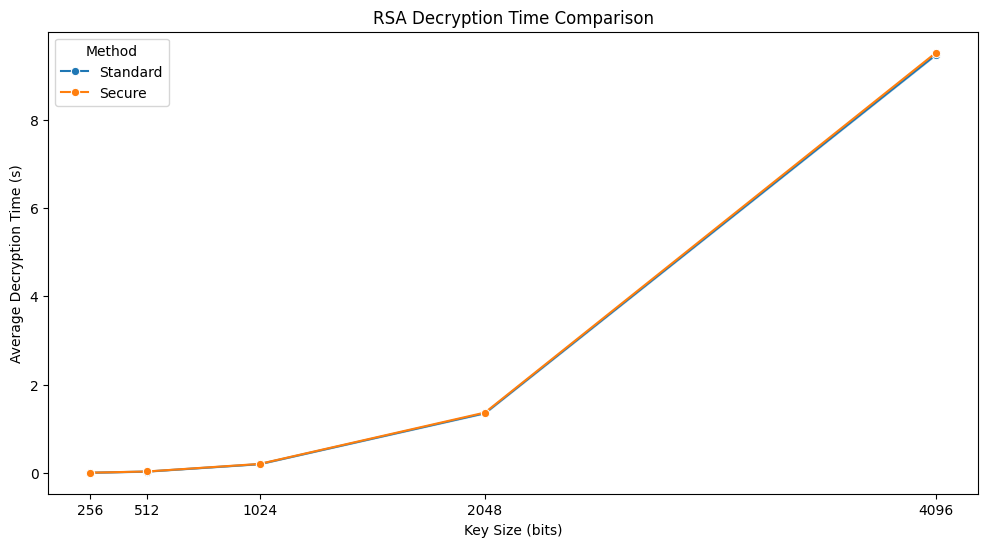

In [4]:
# Decryption Time Comparison
plt.figure(figsize=(12, 6))
sns.lineplot(x='Key Size', y='Decryption Time (s)', hue='Method', data=df, marker='o')
plt.title('RSA Decryption Time Comparison')
plt.xticks(key_sizes, key_sizes)
plt.xlabel('Key Size (bits)')
plt.ylabel('Average Decryption Time (s)')
plt.show()

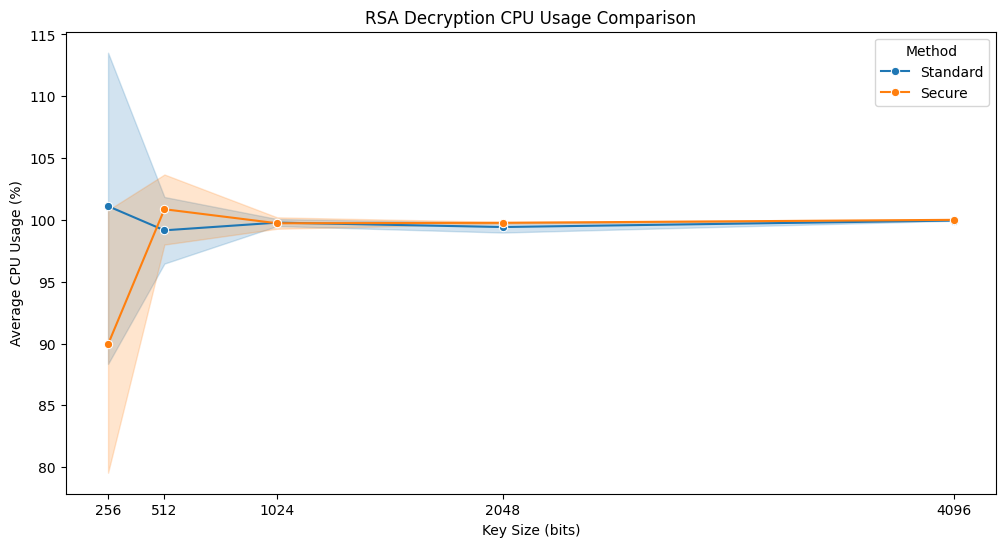

In [5]:
# CPU Usage Comparison
plt.figure(figsize=(12, 6))
sns.lineplot(x='Key Size', y='CPU Usage (%)', hue='Method', data=df, marker='o')
plt.title('RSA Decryption CPU Usage Comparison')
plt.xticks(key_sizes, key_sizes)
plt.xlabel('Key Size (bits)')
plt.ylabel('Average CPU Usage (%)')
plt.show()

In [6]:
# Memory Usage Comparison
plt.figure(figsize=(12, 6))
sns.lineplot(x='Key Size', y='Memory Usage (MB)', hue='Method', data=df, marker='o')
plt.title('RSA Decryption Memory Usage Comparison')
plt.xscale('log')
plt.xticks(key_sizes, key_sizes)
plt.xlabel('Key Size (bits)')
plt.ylabel('Average Memory Usage (MB)')
plt.show()

ValueError: Could not interpret value `Memory Usage (MB)` for `y`. An entry with this name does not appear in `data`.

<Figure size 1200x600 with 0 Axes>